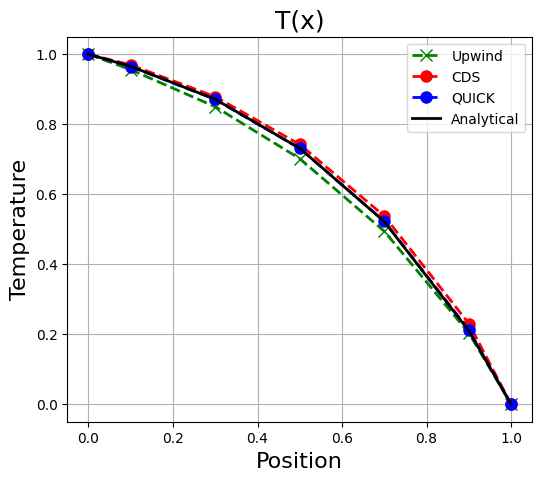

Temperature QUICK: [1.         0.96482596 0.87069826 0.73087635 0.52256802 0.21220362
 0.        ]
Temperature Upwind: [1.         0.95586844 0.84995268 0.70167063 0.49407577 0.20344296
 0.        ]
Temperature CDS: [1.         0.96966824 0.87867298 0.74218009 0.53744075 0.23033175
 0.        ]


In [1]:
#****************1D convection-diffusion CDS, Upwind and QUICK Scheme*******************
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0     #Domain Length (m)
N = 5     # Number of internal nodes
rho = 1.0     # Density kg/m^3
u = 0.2     # Velocity m/s
Gamma = 0.1   # Diffusivity
h = L / N
F = rho * u   # Convective mass flux
D = Gamma / h   # Diffusion conductance

# Boundary conditions
phi0 = 1.0  # Left boundary
phiB = 0.0  # Right boundary

# Grid definition
x_internal = np.linspace(h / 2, L - h / 2, N)
x_full = np.insert(x_internal, 0, 0.0)
x_full = np.append(x_full, L)


# ------------------- QUICK Scheme -------------------
phi = np.zeros(N)
phi_new = np.zeros_like(phi)
epsilon = 1e-8
error = 1.0
iterations = 0
error_list = []

while error > epsilon and iterations < 10000:
    for i in range(N):
        if i == 0:
            aW = 0
            aE = D + (1 / 3) * D - (3 / 8) * F
            aWW = 0
            Sp = -((8 / 3) * D + (2 / 8) * F + F)
            Su = ((8 / 3) * D + (2 / 8) * F + F) * phi0
            aP = aW + aE + aWW - Sp
            phi_new[i] = (aE * phi[i + 1] + Su) / aP

        elif i == 1:
            aW = D + (7 / 8) * F + (1 / 8) * F
            aE = D - (3 / 8) * F
            aWW = 0
            Sp = (1 / 4) * F
            Su = -Sp * phi0
            aP = aW + aE + aWW - Sp
            phi_new[i] = (aW * phi[i - 1] + aE * phi[i + 1] + Su) / aP

        elif i == N - 1:
            aW = D + (1 / 3) * D + (6 / 8) * F
            aE = 0
            aWW = -(1 / 8) * F
            Sp = -((8 / 3) * D - F)
            Su = (8 / 3) * (D - F) * phiB
            aP = aW + aE + aWW - Sp
            phi_new[i] = (aW * phi[i - 1] + aWW * phi[i - 2] + Su) / aP

        else:
            aW = D + (6 / 8) * F + (1 / 8) * F
            aE = D - (3 / 8) * F
            aWW = -(1 / 8) * F
            Sp = 0
            Su = 0
            aP = aW + aE + aWW - Sp
            phi_new[i] = (aW * phi[i - 1] + aE * phi[i + 1] + aWW * phi[i - 2]) / aP

    error = np.sum(np.abs(phi_new - phi))
    error_list.append(error)
    phi[:] = phi_new[:]
    iterations += 1

phi_quick = np.zeros(N + 2)
phi_quick[0] = phi0
phi_quick[-1] = phiB
phi_quick[1:-1] = phi


# ------------------- Upwind Scheme -------------------
T_upwind_internal = np.zeros(N)
T_upwind_new_internal = np.zeros_like(T_upwind_internal)
epsilon = 1e-8
error = 1.0
iterations = 0

while error > epsilon and iterations < 10000:
    for i in range(N):
        # Adjusting indices for internal nodes
        if i == 0: # Left boundary adjacent node
            aW = 0 # No node to the west within the internal array
            aE = D
            sp = -(2*Gamma/h + rho*u)
            su = (2*Gamma/h + rho*u) * phi0
            aP = aW + aE - sp # Include boundary contribution
            T_upwind_new_internal[i] = ( aW * T_upwind_internal[i - 1] + aE * T_upwind_internal[i + 1] + su) / aP
        elif i == N - 1: # Right boundary adjacent node
            aW = D + F
            aE = 0 # No node to the east within the internal array
            sp = -2*D
            su = 2 * D * phiB
            aP = aW + aE - sp # Include boundary contribution
            T_upwind_new_internal[i] = ( aW * T_upwind_internal[i - 1] + su) / aP
        else: # Internal nodes
            aW = D + F
            aE = D
            sp = 0
            su = 0
            aP = aW + aE - sp
            T_upwind_new_internal[i] = ( aW * T_upwind_internal[i - 1] + aE * T_upwind_internal[i + 1] + su) / aP

    error = np.sum(np.abs(T_upwind_new_internal - T_upwind_internal))
    T_upwind_internal[:] = T_upwind_new_internal[:]
    iterations += 1

T_upwind_modified = np.zeros(N + 2)
T_upwind_modified[0] = phi0
T_upwind_modified[-1] = phiB
T_upwind_modified[1:-1] = T_upwind_internal


# ------------------- CDS Scheme -------------------
T_cds_internal = np.zeros(N)
T_cds_new_internal = np.zeros_like(T_cds_internal)
epsilon = 1e-8
error = 1.0
iterations = 0

while error > epsilon and iterations < 10000:
    for i in range(N):
        # Adjusting indices for internal nodes
        if i == 0: # Left boundary adjacent node
            aW = 0 # No node to the west within the internal array
            aE = Gamma / h - rho * u / 2
            sp = -(2*Gamma/h + rho*u)
            su = (2*Gamma/h + rho*u) * phi0
            aP = aW + aE - sp
            T_cds_new_internal[i] = (aE * T_cds_internal[i + 1] + su) / aP

        elif i == N - 1: # Right boundary adjacent node
            aW = Gamma / h + rho * u / 2
            aE = 0 # No node to the east within the internal array
            sp = -(2*Gamma/h - rho*u)
            su = (2*Gamma/h - rho*u) * phiB
            aP = aW + aE - sp
            T_cds_new_internal[i] = (aW * T_cds_internal[i - 1] + su) / aP

        else: # Internal nodes
            aW = Gamma / h + rho * u / 2
            aE = Gamma / h - rho * u / 2
            sp = 0
            su = 0
            aP = aW + aE - sp
            T_cds_new_internal[i] = (aW * T_cds_internal[i - 1] + aE * T_cds_internal[i + 1] + su) / aP

    error = np.sum(np.abs(T_cds_new_internal - T_cds_internal))
    T_cds_internal[:] = T_cds_new_internal[:]
    iterations += 1

T_cds_modified = np.zeros(N + 2)
T_cds_modified[0] = phi0
T_cds_modified[-1] = phiB
T_cds_modified[1:-1] = T_cds_internal


# ------------------- Analytical Solution -------------------
def analytical_solution(x):
    Pe = rho * u * L / Gamma
    return (np.exp(Pe * x / L) - np.exp(Pe)) / (1 - np.exp(Pe))

phi_analytical = analytical_solution(x_full)

# ------------------- Plotting -------------------
plt.figure(figsize=(6, 5))
plt.plot(x_full, T_upwind_modified, 'gx--', label='Upwind', linewidth=2, markersize=8)
plt.plot(x_full, T_cds_modified, 'ro--', label='CDS', linewidth=2, markersize=8)
plt.plot(x_full, phi_quick, 'bo--', label='QUICK', linewidth=2, markersize=8)
plt.plot(x_full, phi_analytical, 'k-', label='Analytical', linewidth=2)
plt.xlabel('Position', size=16)
plt.ylabel('Temperature', size=16)
plt.title('T(x)', size=18)
plt.grid(True)
plt.legend()
plt.show()

print("Temperature QUICK:", phi_quick)
print("Temperature Upwind:", T_upwind_modified)
print("Temperature CDS:", T_cds_modified)